In [29]:
# !pip install --quiet optuna
# !pip install --quiet stellargraph

In [3]:
import os
import optuna
from optuna.trial import TrialState
import pandas as pd
import numpy as np
import torch
import random
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Data prep

In [4]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('../Data/grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [18]:
def data_preparation(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # only PM2_5
    df = df[['dateTime','temperature','humidity','lat','long','pm2_5']]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 

    # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')[['pm2_5', 'temperature', 'humidity']]   
    columns = df.columns
#     df = df[columns[2:]]
    df = df.fillna(0)
    
    return df

In [19]:
df = data_preparation('../dataset/Jan/2021-01-10_all.csv')

In [29]:
df_pm2_5 = df['pm2_5']
df_temp = df['temperature']
df_hum = df['humidity']
# df_pm2_5.head()
# df_temp.head()
# df_hum.head()

In [20]:
df

pm2_5                                      \
dateTime                  360         540         720         900    
lat_grid long_grid                                                   
0        22         119.087413  135.793269  105.937761   82.932755   
1        19         137.315789  169.615385  139.928571    0.000000   
         20         124.347826  159.833333  125.048780    0.000000   
         21         122.465278  118.129252  106.260870   81.172840   
         22         125.560345  113.309633   88.147826   89.102857   
...                        ...         ...         ...         ...   
18       20           0.000000  125.379310  132.797753    0.000000   
         23          81.700000  103.142857    0.000000  102.366667   
         24         117.448980  113.137931    0.000000  128.777778   
19       19           0.000000  117.083333  120.027027    0.000000   
         20           0.000000  119.317460  120.675000    0.000000   

                                           temperature                        \
dateTime                  1080        1260        360        540        720    
lat_grid long_grid                                                             
0        22         180.533446  176.964782   20.437448  25.354076  28.851612   
1        19         153.285714  190.300000   17.939474  20.605385  25.509643   
         20         134.812500  201.476190   17.698478  20.542222  25.721463   
         21         137.221311  178.062500   20.738403  24.538027  28.378043   
         22         151.892157  181.524823   21.137069  26.173486  32.347005   
...                        ...         ...         ...        ...        ...   
18       20         120.034483  225.675000    0.000000  19.583966  26.101461   
         23           0.000000  160.581395   23.817500  28.640000   0.000000   
         24           0.000000  194.777778   23.825918  28.746897   0.000000   
19       19         129.102041  226.950000    0.000000  19.673750  25.150000   
         20         128.141667  223.823529    0.000000  19.815397  24.235125   

                                                      humidity             \
dateTime                 900        1080       1260       360        540    
lat_grid long_grid                                                          
0        22         34.365597  29.167875  26.959574  46.947291  34.928615   
1        19          0.000000  27.346429  25.814000  53.241725  45.849159   
         20          0.000000  27.297188  25.795238  53.936014  45.746148   
         21         33.977037  28.769016  26.038958  46.311564  36.434424   
         22         34.396324  28.661993  25.978511  45.306746  33.534083   
...                       ...        ...        ...        ...        ...   
18       20          0.000000  31.217980  27.246833   0.000000  48.654314   
         23         31.688333   0.000000  29.181163  36.945166  27.702288   
         24         31.591111   0.000000  29.250000  37.121632  27.070818   
19       19          0.000000  31.312653  28.662000   0.000000  48.462687   
         20          0.000000  31.297333  28.642353   0.000000  48.068980   

                                                                
dateTime                 720        900        1080       1260  
lat_grid long_grid                                              
0        22         28.408670  19.583093  28.992963  32.362980  
1        19         32.811070   0.000000  29.876046  34.349707  
         20         32.601944   0.000000  29.788757  34.137602  
         21         28.025253  20.741115  29.359471  34.010874  
         22         22.274268  19.327139  29.293920  34.303552  
...                       ...        ...        ...        ...  
18       20         33.608245   0.000000  26.606311  34.769434  
         23          0.000000  22.842904   0.000000  28.944041  
         24          0.000000  23.066189   0.000000  29.023112  
19       19         35.570233   0.000000  26.459483  32.297070  

In [40]:
def train_test_split(df, grid_points_indices, train_size):
    # random.seed(10)
    time_len = df.shape[1]
    train_size = int(time_len * train_size) 
    train_data = df.iloc[:, :train_size]
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    test_data = df.iloc[:, train_size:]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [41]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [96]:
def sequence_data_preparation(seq_len, pre_len, train_data_pm2_5, train_data_temp, train_data_hum, test_data_pm2_5, test_data_temp, test_data_hum):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data_pm2_5.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data_pm2_5[:, i : i + seq_len + pre_len]
        b = train_data_temp[:, i : i + seq_len + pre_len]
        c = train_data_hum[:, i : i + seq_len + pre_len]
        d = np.concatenate((a[:, :seq_len] , b[:, :seq_len] , c[:, :seq_len]), axis=1)
        trainX.append(d)
        trainY.append(a[:, -1])

    for i in range(test_data_pm2_5.shape[1] - int(seq_len + pre_len - 1)):
        a = test_data_pm2_5[:, i : i + seq_len + pre_len]
        b = test_data_temp[:, i : i + seq_len + pre_len]
        c = test_data_hum[:, i : i + seq_len + pre_len]
        d = np.concatenate((a[:, :seq_len] , b[:, :seq_len] , c[:, :seq_len]), axis=1)
        testX.append(d)
        testY.append(a[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    # print(trainX)

    return trainX, trainY, testX, testY

In [94]:
def prepare_train_data(grid_points_indices, train_size = 0.8):
    train_data_pm2_5, test_data_pm2_5 = train_test_split(df_pm2_5, grid_points_indices, train_size)
    train_data_temp, test_data_temp = train_test_split(df_temp, grid_points_indices, train_size)
    train_data_hum, test_data_hum = train_test_split(df_hum, grid_points_indices, train_size)

    train_scaled_pm2_5, test_scaled_pm2_5 = scale_data(train_data_pm2_5, test_data_pm2_5)
    train_scaled_temp, test_scaled_temp = scale_data(train_data_temp, test_data_temp)
    train_scaled_hum, test_scaled_hum = scale_data(train_data_hum, test_data_hum)

    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled_pm2_5, train_scaled_temp, train_scaled_hum, test_scaled_pm2_5, test_scaled_temp, test_scaled_hum)

    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data_pm2_5

# Training

In [44]:
def my_loss(y_true, y_pred):
    loss = torch.mean((y_pred[y_true>0]-y_true[y_true>0])**2)
    return loss

In [45]:
def eval_model(model, testX, testY):
    output = model(torch.Tensor(testX))
    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)
    ## Rescale model predicted values
    test_output = np.array((output.detach().numpy() * (max_pm - min_pm)) + min_pm)
    # # Masked predicted values\
    mask_test = torch.sign(torch.Tensor(testY))
    test_output = torch.Tensor(test_output)*(mask_test)
    test_mse = my_loss(torch.Tensor(test_true), torch.Tensor(test_output))
    test_rmse = torch.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [46]:
def get_out_df(train_rmse, validation_rmse):
    max_pm = train_data.max()
    min_pm = train_data.min()
    scale_factor = max_pm - min_pm
    df = pd.DataFrame()
    df['Mean Train loss'] = [sum(train_rmse)*scale_factor/len(train_rmse)]
    df['Last Train loss'] = [train_rmse[-1]*scale_factor]
    df['Mean Test loss'] = [sum(validation_rmse)*scale_factor/len(validation_rmse)]
    df['Last Test loss'] = [validation_rmse[-1]*scale_factor]
    # df['Train time callbacks'] = [sum(cb.logs)]
    return df

In [47]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Initialize The Model

In [106]:
df = data_preparation('../dataset/Dec/2020-12-1_all.csv')
for i in range(2, 20):
    datafile = '../dataset/Dec/2020-12-'
    datafile +=  str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)

In [107]:
df_pm2_5 = df['pm2_5']
df_temp = df['temperature']
df_hum = df['humidity']

In [108]:
df_temp

dateTime                 360        540        720      900        1080  \
lat_grid long_grid                                                        
0        21          0.000000   0.000000   0.000000   0.0000   0.000000   
         22         24.238188  29.692245  35.580109  32.0619  35.437015   
1        19          0.000000   0.000000   0.000000   0.0000   0.000000   
         20          0.000000   0.000000   0.000000   0.0000   0.000000   
         21         24.523214  28.353030  33.536923  37.2782  36.005294   
...                       ...        ...        ...      ...        ...   
28       4           0.000000   0.000000   0.000000   0.0000   0.000000   
         5           0.000000   0.000000   0.000000   0.0000   0.000000   
29       2           0.000000   0.000000   0.000000   0.0000   0.000000   
         3           0.000000   0.000000   0.000000   0.0000   0.000000   
         4           0.000000   0.000000   0.000000   0.0000   0.000000   

dateTime                 1260       360        540        720        900   \
lat_grid long_grid                                                          
0        21          0.000000   0.000000   0.000000   0.000000   0.000000   
         22         35.610133  23.103529  31.147679  34.550195  39.156444   
1        19          0.000000   0.000000   0.000000   0.000000   0.000000   
         20          0.000000   0.000000   0.000000   0.000000   0.000000   
         21         29.395000   0.000000   0.000000  30.117857   0.000000   
...                       ...        ...        ...        ...        ...   
28       4           0.000000   0.000000   0.000000   0.000000   0.000000   
         5           0.000000   0.000000   0.000000   0.000000   0.000000   
29       2           0.000000   0.000000   0.000000   0.000000   0.000000   
         3           0.000000   0.000000   0.000000   0.000000   0.000000   
         4           0.000000   0.000000   0.000000   0.000000   0.000000   

dateTime            ...       720        900        1080       1260  \
lat_grid long_grid  ...                                               
0        21         ...  34.350000   0.000000   0.000000   0.000000   
         22         ...  32.946352  35.546333  30.688788  31.350134   
1        19         ...  26.944286  31.823333  29.419130  27.154500   
         20         ...  26.800526  31.763103  29.577895  27.055000   
         21         ...  30.894403  33.292378  32.119928  29.716043   
...                 ...        ...        ...        ...        ...   
28       4          ...   0.000000   0.000000   0.000000   0.000000   
         5          ...   0.000000   0.000000   0.000000   0.000000   
29       2          ...   0.000000   0.000000   0.000000   0.000000   
         3          ...   0.000000   0.000000   0.000000   0.000000   
         4          ...   0.000000   0.000000   0.000000   0.000000   

dateTime                 360        540        720        900        1080  \
lat_grid long_grid                                                          
0        21          0.000000  23.280000   0.000000   0.000000   0.000000   
         22         21.036742  26.832014  30.725353  26.156020  34.497279   
1        19          0.000000  18.448000  29.761176   0.000000  29.060526   
         20          0.000000  18.804857  29.785600   0.000000  28.933611   
         21         21.079370  23.898377  30.017310  31.996389  32.440952   
...                       ...        ...        ...        ...        ...   
28       4           0.000000   0.000000   0.000000   0.000000   0.000000   
         5           0.000000   0.000000   0.000000   0.000000   0.000000   
29       2           0.000000   0.000000   0.000000   0.000000   0.000000   
         3           0.000000   0.000000   0.000000   0.000000   0.000000   
         4           0.000000   0.000000   0.000000   0.000000   0.000000   

dateTime                 1260  
lat_grid long_grid             
0        21          0.000000  


In [109]:
df.shape

(231, 342)

In [110]:
trainX, trainY, testX, testY, train_data = prepare_train_data(grid_points_indices, train_size = 0.86)

(95, 270, 9)
(95, 270)
(13, 270, 9)
(13, 270)


In [111]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(95, 270, 9) (95, 270) (13, 270, 9) (13, 270)


In [112]:
trainX[0].shape, trainY[0].shape, trainX.shape, trainY.shape

((270, 9), (270,), (95, 270, 9), (95, 270))

In [138]:
from gcn_lstm import GCN_LSTM
import numpy as np
import torch
adj = adj.astype(np.float32)
model=GCN_LSTM(torch.from_numpy(adj), grid_size = 270, seq_len = 9, gc_sizes = [8, 4], lstm_sizes = [4])
optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-05)

In [139]:
for param in model.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([270, 4])
<class 'torch.nn.parameter.Parameter'> torch.Size([270])


In [140]:

def train_model(model, optimizer, trainX, trainY, testX, testY, n_epochs, batch_size):
    # convert all data to tensor
    trainX = torch.from_numpy(trainX.astype(np.float32))
    trainY = torch.from_numpy(trainY.astype(np.float32))
    testX = torch.from_numpy(testX.astype(np.float32))
    testY = torch.from_numpy(testY.astype(np.float32))
    
    trainDs = TensorDataset(trainX, trainY)
    testDs = TensorDataset(testX, testY)
    trainLoader = DataLoader(trainDs, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(testDs, batch_size=batch_size, shuffle=False)

    train_mse, train_rmse, validation_mse, validation_rmse=[], [], [], []
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        for _, (inputs, targets) in enumerate(trainLoader):
            model.train()
            outputs = model(inputs)
            loss = my_loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(inputs)
        
        with torch.no_grad():
            for _, (inputs, targets) in enumerate(testLoader):
                model.eval()
                outputs = model(inputs)
                loss = my_loss(outputs, targets)
                valid_loss += loss.item()*len(inputs)

        train_loss /= len(trainX)
        valid_loss /= len(testX)
        train_mse.append(train_loss)
        validation_mse.append(valid_loss)
        train_rmse.append(math.sqrt(train_loss))
        validation_rmse.append(math.sqrt(valid_loss))

        if((epoch+1)%10==0):
            print(f'Epoch {epoch+1} \t Train Loss: ', {train_loss}, 'Valid Loss: ', {valid_loss})

    return train_mse, train_rmse, validation_mse, validation_rmse

Epoch 10 	 Train Loss:  {0.01370842441132194} Valid Loss:  {0.010064562925925622}
Epoch 20 	 Train Loss:  {0.011566771243355776} Valid Loss:  {0.00951590847510558}
Epoch 30 	 Train Loss:  {0.011399127444938609} Valid Loss:  {0.00942547468898388}
Epoch 40 	 Train Loss:  {0.010893957101200757} Valid Loss:  {0.00945142233887544}
Epoch 50 	 Train Loss:  {0.010814621260291651} Valid Loss:  {0.009424935238292584}
Epoch 60 	 Train Loss:  {0.010843079929289064} Valid Loss:  {0.009316074232069345}
Epoch 70 	 Train Loss:  {0.01072933537101275} Valid Loss:  {0.00933012144210247}
Epoch 80 	 Train Loss:  {0.010858513561910704} Valid Loss:  {0.009350502433685156}
Epoch 90 	 Train Loss:  {0.010777143320362819} Valid Loss:  {0.009359124976281937}
Epoch 100 	 Train Loss:  {0.010814356421561618} Valid Loss:  {0.009298584567239651}
Epoch 110 	 Train Loss:  {0.01075839065015316} Valid Loss:  {0.009405577125457617}
Epoch 120 	 Train Loss:  {0.010879394990441046} Valid Loss:  {0.00932545644732622}
Epoch 130

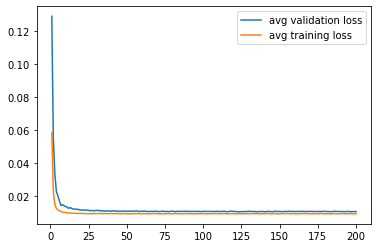

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,73.079809,70.066941,66.848959,65.806972


In [141]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 200, 10)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 201), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 201), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

In [142]:
train_mse

[0.1290924560866858,
 0.05480632558465004,
 0.03363018786828769,
 0.022753643362145675,
 0.020212342276384954,
 0.016828861528713452,
 0.014348092390910575,
 0.014815320309839751,
 0.014192999242559859,
 0.01370842441132194,
 0.013414312938326284,
 0.01259078801070389,
 0.013079867845303133,
 0.012514604745726837,
 0.012234305374716458,
 0.012152853054239562,
 0.011906630261556098,
 0.01213494673567383,
 0.011634215026309616,
 0.011566771243355776,
 0.011601497272127554,
 0.01149542247386355,
 0.011548150575866825,
 0.011527926219921363,
 0.011502756590121671,
 0.011110932566225529,
 0.011289449727260753,
 0.011209815495500439,
 0.011147960848910244,
 0.011399127444938609,
 0.011271601003643713,
 0.01126433467786563,
 0.01103530510475761,
 0.011203673521154806,
 0.010940292408983959,
 0.01101164926627749,
 0.01106080721671644,
 0.011060036620811411,
 0.010916939495425475,
 0.010893957101200757,
 0.011191133850891339,
 0.010988162805963504,
 0.010894880728109888,
 0.011005130204323092,


Epoch 10 	 Train Loss:  {0.010940379071000376} Valid Loss:  {0.009434464566696148}
Epoch 20 	 Train Loss:  {0.010792087322395099} Valid Loss:  {0.009270388561372574}
Epoch 30 	 Train Loss:  {0.010772447077263343} Valid Loss:  {0.009405863292228717}
Epoch 40 	 Train Loss:  {0.010958575668107522} Valid Loss:  {0.009460339394326393}
Epoch 50 	 Train Loss:  {0.01108421993098761} Valid Loss:  {0.009380866451045642}
Epoch 60 	 Train Loss:  {0.01075086325995232} Valid Loss:  {0.0093217957048462}
Epoch 70 	 Train Loss:  {0.01085509467673929} Valid Loss:  {0.009299044174930224}
Epoch 80 	 Train Loss:  {0.010760908137614789} Valid Loss:  {0.009335809673827428}
Epoch 90 	 Train Loss:  {0.010938684407033418} Valid Loss:  {0.009270828038167495}
Epoch 100 	 Train Loss:  {0.010761018670899304} Valid Loss:  {0.009376178567226116}


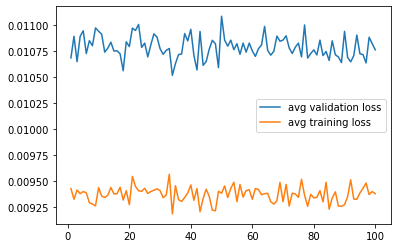

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,70.660652,70.578507,65.854229,65.880776


In [143]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 100, 5)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

Epoch 10 	 Train Loss:  {0.01059842037135049} Valid Loss:  {0.009346965700387955}
Epoch 20 	 Train Loss:  {0.010617787596818648} Valid Loss:  {0.009483435191214085}
Epoch 30 	 Train Loss:  {0.010713944437080307} Valid Loss:  {0.009492737241089344}
Epoch 40 	 Train Loss:  {0.010542506553036603} Valid Loss:  {0.009235422126948833}
Epoch 50 	 Train Loss:  {0.010639324921526408} Valid Loss:  {0.009316270239651203}
Epoch 60 	 Train Loss:  {0.010692350061512307} Valid Loss:  {0.009312639012932777}
Epoch 70 	 Train Loss:  {0.01055149119347334} Valid Loss:  {0.009252529591321945}
Epoch 80 	 Train Loss:  {0.010701033884757443} Valid Loss:  {0.009337879717350006}
Epoch 90 	 Train Loss:  {0.010640692838320606} Valid Loss:  {0.009294153191149235}
Epoch 100 	 Train Loss:  {0.010606866339711767} Valid Loss:  {0.00955137237906456}


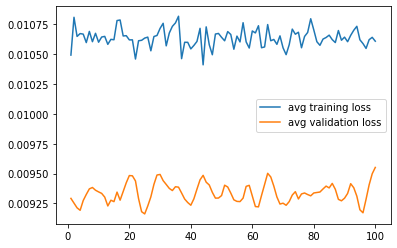

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,70.161593,70.071162,65.744412,66.493419


In [144]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model,optimizer, trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)